## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [2]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [3]:
import numpy as np
import keras
from matplotlib import pyplot as plt
import cv2

Using plaidml.keras.backend backend.


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

Now let's explore some of the data, for starters we will use the following Kaggle dataset: [lego-brick-images](https://www.kaggle.com/joosthazelzet/lego-brick-images)

It's a fairly simple dataset containing renders of some LEGO pieces

In [4]:
dataset_path = "../../LEGO_brick_images_v1/"
dataset_output = "./output"

In [5]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [49]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), target_size=(200,200), shuffle=True, class_mode='categorical')

Found 2785 images belonging to 10 classes.
Found 1194 images belonging to 10 classes.


In [ ]:
To show some of the images generated we can use matplotlib

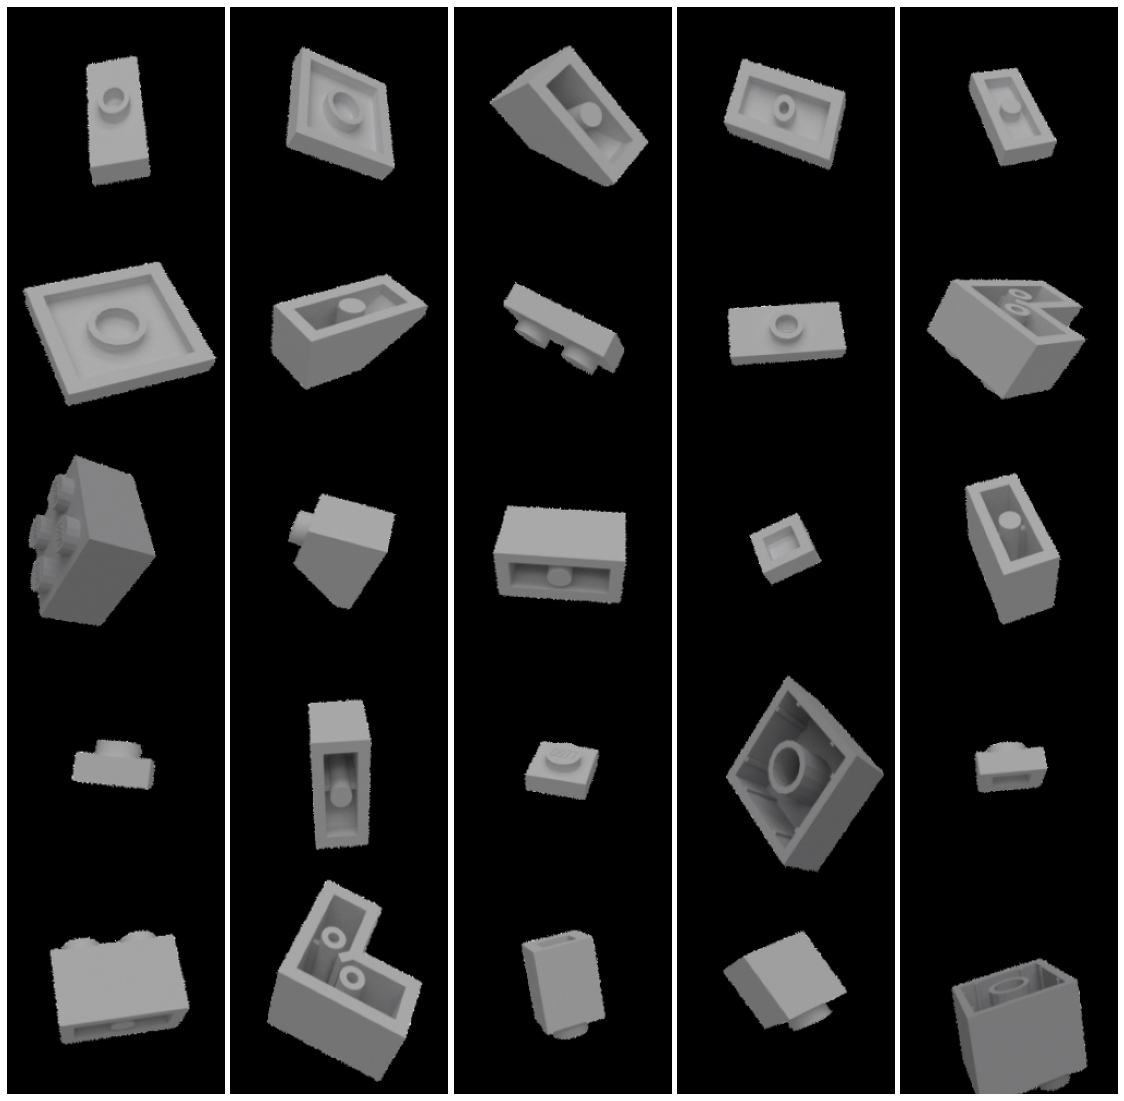

In [50]:
images = train_generator[0][0]
row=5 #max is 5 since batches are set to 32 images, 6 would be 36 and would error out
col=5
fig, axs = plt.subplots(row,col, figsize=(row*4,col*4), gridspec_kw={"wspace":0,"hspace":0})
for x in range(row):
    for y in range(col):
        axs[x,y].axis("off")
        axs[x,y].imshow(images[(x*row)+(y)])

Now to declare a model and modify it, we can also use preexisting ones like VGG16 or ResNet but for this test we are using a simple one

In [10]:
from keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Activation
from keras.models import Sequential, Input, Model

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(200,200,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation="softmax"))

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20072512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 20,074,058
Trainable params: 20,074,058
Non-trainable params: 0
___________

In [11]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [16]:
from keras.optimizers import SGD

opt = SGD(lr=1e-3)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = 100, 
    validation_data  = validation_generator,
    validation_steps = 100,
    epochs = 50, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/50
100/100 [==============================] - 47s 467ms/step - loss: 2.1949 - acc: 0.1806 - val_loss: 2.0394 - val_acc: 0.3200

Epoch 00001: val_loss improved from 2.30402 to 2.03945, saving model to ./base.model
Epoch 2/50
100/100 [==============================] - 40s 396ms/step - loss: 1.9822 - acc: 0.2902 - val_loss: 1.7629 - val_acc: 0.4952

Epoch 00002: val_loss improved from 2.03945 to 1.76289, saving model to ./base.model
Epoch 3/50
100/100 [==============================] - 39s 392ms/step - loss: 1.8189 - acc: 0.3319 - val_loss: 1.5443 - val_acc: 0.5764

Epoch 00003: val_loss improved from 1.76289 to 1.54428, saving model to ./base.model
Epoch 4/50
100/100 [==============================] - 40s 399ms/step - loss: 1.7125 - acc: 0.3673 - val_loss: 1.4874 - val_acc: 0.5402

Epoch 00004: val_loss improved from 1.54428 to 1.48744, saving model to ./base.model
Epoch 5/50
100/100 [==============================] - 40s 397ms/step - loss: 1.6409 - acc: 0.4065 - val_loss: 1.3253

In [12]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

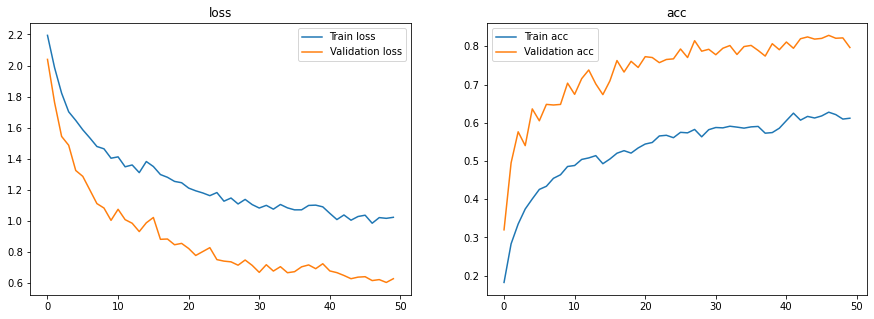

In [18]:
show_final_history(history)

We can try and test the model on random new images

In [13]:
#image_path = "../../LEGO_brick_images_v1/2357 Brick corner 1x2x2/201706171206-0001.png"
image_path = "../../LEGO_brick_images_v1/3004 Brick 1x2/0003.png"
image = cv2.imread(image_path)

from numpy import array
json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = np.expand_dims(image, axis=0)
prediction = loaded_model.predict_classes(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                20072512  
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 20,074,058
Trainable params: 20,074,058
Non-trainable params: 0
________________________________________________________________

In [14]:
prediction[0]

2

Since the classes are sorted alphabetically, an item from the third folder should give us a number `2` from `prediction[0]`.